In [237]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner
import dynesty

In [224]:
muX, muY = 3, 5
sigmaX, sigmaY = 1, 1
sigma = np.array([sigmaX, sigmaY])
rhoXY = 0.3
mean = np.array([muX, muY])
cov = np.array([[sigmaX, rhoXY], [rhoXY, sigmaY]])

size = 1000

seed = 0
np.random.seed(seed)
data = np.random.multivariate_normal(mean, cov, size=size)

In [225]:
def log_likelihood(theta):
    
    muX, muY, sigmaX, sigmaY, rhoXY = theta
    mean = np.array([muX, muY])
    covXY =  np.array([[sigmaX, rhoXY], [rhoXY, sigmaY]])
    
    log_lr = 0
    
    for i in range(len(data)):
    
         log_lr += ((data[i,:] - mean).T@np.linalg.inv(covXY))@(data[i,:] - mean)
        
    return -0.5 * (len(data)*np.log(2*np.pi*np.linalg.det(covXY)) + float(log_lr.flatten()))

def log_prior(theta):
    
    muX, muY, sigmaX, sigmaY, rhoXY = theta
    
    if (1 < muX < 5 and 3 < muY < 7 and 0 < sigmaX < 2 and 0 < sigmaY < 2 
                                and 0.1 < rhoXY < 0.5):
        
        return 0.0
    
    return -np.inf

def log_probability(theta):
    
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        
        return -np.inf
    
    return lp + log_likelihood(theta)

#-- Using emcee sampler ---
pos = np.array([muX, muY, sigmaX, sigmaY, rhoXY]) + 1e-2 * np.random.randn(16, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [33:16<00:00,  5.01it/s]


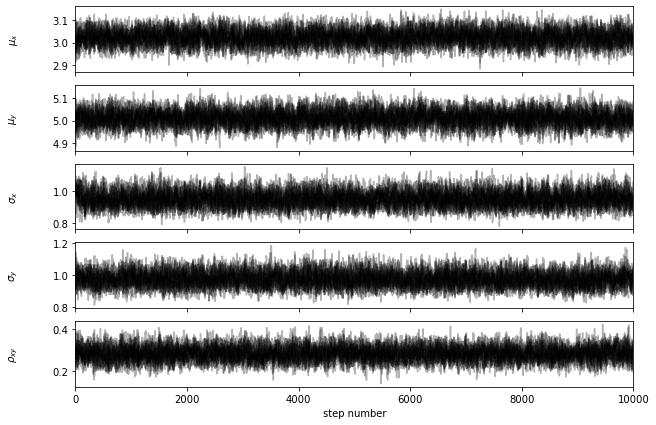

In [226]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\mu_x$", r"$\mu_y$", r"$\sigma_x$", r"$\sigma_y$", r"$\rho_{xy}$"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [228]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10560, 5)


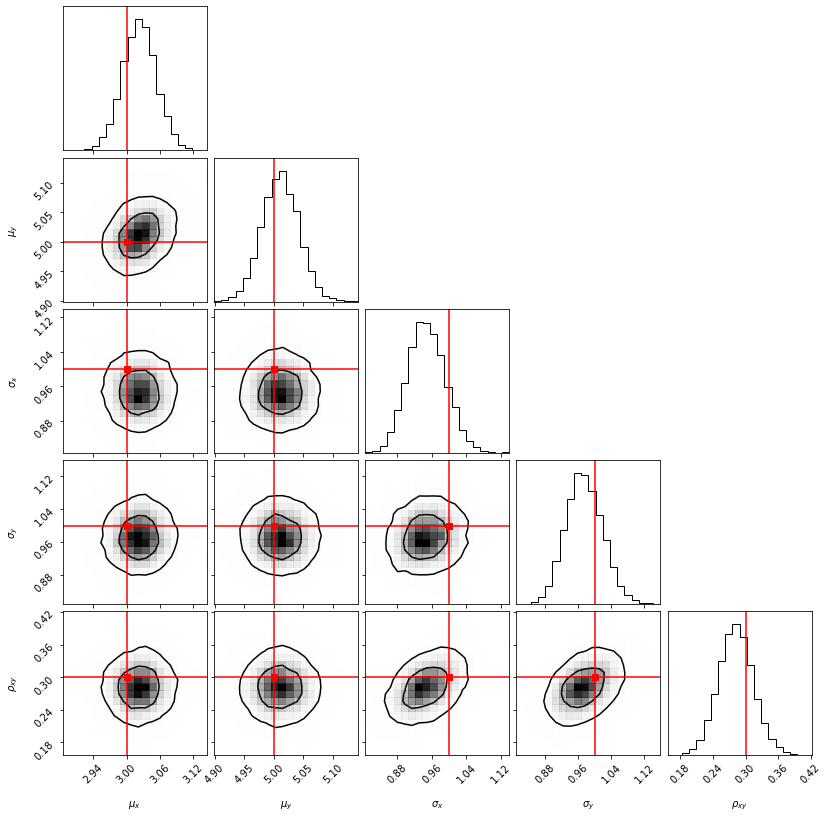

In [234]:
fig = corner.corner(flat_samples, labels=labels, smooth=0.5, levels=[0.50, 0.90], truths=[3, 5, 1, 1, 0.3], \
                    truth_color='r', plot_datapoints=False);